# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min, max, split, udf, count
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler
import seaborn as sns
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, DecisionTreeClassifier, NaiveBayes
import numpy as np
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator,BinaryClassificationEvaluator

In [2]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("capstone Sparkify") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
#read data
sparkify_data = 'mini_sparkify_event_data.json'
df = spark.read.json(sparkify_data)
df.persist()
df.count()
df.take(5)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

In [4]:
def clean_data(df):   
    '''
    input: original dataframe
    
    outpu: dataframe after cleaning
    '''
    df_clean = df.dropna(how = "any", subset = ["userId", "sessionId"])
    df_clean.select("userId").dropDuplicates()
    df_clean.select("sessionId").dropDuplicates()
    df_clean = df_clean.filter(df_clean.userId!="")
    return df_clean

In [5]:
df_clean = clean_data(df)
df_clean.count()

278154

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [6]:
df_clean.select("page").dropDuplicates().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



In [7]:
def create_churn_column(df_clean):
    churn_users = df_clean.filter(df_clean.page=="Cancellation Confirmation").select("userId").dropDuplicates()
    churn_user_list = [row["userId"] for row in churn_users.collect()]
    df_clean = df_clean.withColumn("churn", df_clean.userId.isin(churn_user_list))
    return df_clean

In [8]:
df_churn = create_churn_column(df_clean)

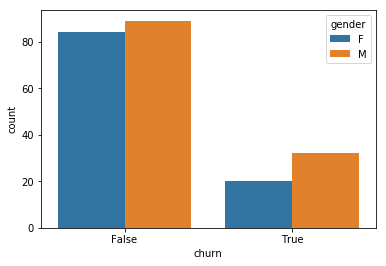

In [9]:
# investigate churns for different genders
df_gender = df_churn.dropDuplicates(["userId", "gender"]).groupby(["churn", "gender"]).count().toPandas()
sns.barplot(x='churn', y='count', hue='gender', data=df_gender)

In [10]:
# investigate different attributes of "churn" and "not churn" and 
def data_distri(df_churn, filtered, aggre_cond):
    df_chur_dist = df_churn.where(filtered).groupby(['churn','userId']).agg(aggre_cond).toPandas()
    return df_chur_dist
def plot_hist(df,column_name):
    df.hist(column_name, by='churn', bins=30, sharey=True, density=1)

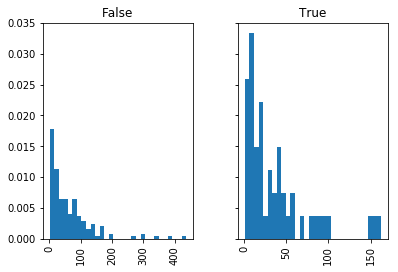

In [11]:
df_chur_up = data_distri(df_churn,df_churn.page=='Thumbs Up',count(col('page')))
plot_hist(df_chur_up,"count(page)")

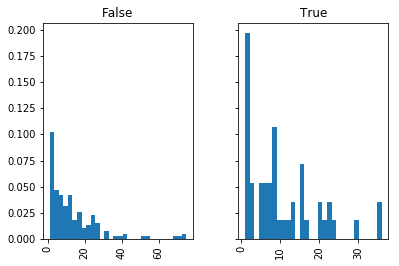

In [12]:
df_chur_down = data_distri(df_churn,df_churn.page=='Thumbs Down',count(col('page')))
plot_hist(df_chur_down,"count(page)")

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [13]:
def extract_features(df_churn,rename,agg_cond,filtered_feature):
    df_selected = df_churn.where(filtered_feature).dropDuplicates().groupby('userId')\
                    .agg(agg_cond.alias(rename)).select(['userId',rename])
    return df_selected

In [14]:
#feature 1
df_number_songs = extract_features(df_churn,'NumberofSongs',count(df_churn.song),df_churn.song!='null')
#feature 2
df_thumb_up = extract_features(df_churn,'ThumbUp',count(df_churn.page),df_churn.page=='Thumbs Up')
#feature 3
df_thumb_down = extract_features(df_churn,'ThumbDown',count(df_churn.page),df_churn.page=='Thumbs Down')
#feature 4
df_artist = extract_features(df_churn,'NumberofArtist',count(df_churn.artist),df_churn.artist!='null')
#feature 5
df_upgrade = extract_features(df_churn,'Upgrade',count(df_churn.page),df_churn.page=='Submit Upgrade')
#feature 6
df_downgrade = extract_features(df_churn,'Downgrade',count(df_churn.page),df_churn.page=='Submit Downgrade')

In [15]:
#feature 7
df_gender = df_churn.select("userId", "gender").dropDuplicates().replace(["M", "F"], ["0", "1"], "gender")
df_gender = df_gender.select("userId",df_gender.gender.cast("int"))

In [16]:
df_combined = df_churn.select(['userId','churn']).dropDuplicates(['userId'])
for df_feature in [df_number_songs,df_thumb_up,df_thumb_down,df_artist,df_upgrade,df_downgrade,df_gender]:
    df_combined = df_combined.join(df_feature,'userId')
df_combined.show()

+------+-----+-------------+-------+---------+--------------+-------+---------+------+
|userId|churn|NumberofSongs|ThumbUp|ThumbDown|NumberofArtist|Upgrade|Downgrade|gender|
+------+-----+-------------+-------+---------+--------------+-------+---------+------+
|    54| true|         2841|    163|       29|          2841|      1|        1|     1|
|    11|false|          647|     40|        9|           647|      2|        1|     1|
|    30|false|         1417|     62|       17|          1417|      1|        1|     0|
|    59|false|          724|     30|        9|           724|      2|        1|     0|
|    85|false|         3616|    192|       38|          3616|      3|        2|     0|
|    35|false|         1610|     71|       14|          1610|      2|        2|     1|
|300002|false|         1610|    140|       11|          1610|      2|        1|     1|
|    96|false|         1802|     92|       24|          1802|      1|        1|     1|
|   100|false|         2682|    148|       

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [17]:
df_combined.dtypes

[('userId', 'string'),
 ('churn', 'boolean'),
 ('NumberofSongs', 'bigint'),
 ('ThumbUp', 'bigint'),
 ('ThumbDown', 'bigint'),
 ('NumberofArtist', 'bigint'),
 ('Upgrade', 'bigint'),
 ('Downgrade', 'bigint'),
 ('gender', 'int')]

In [18]:
#convert data type
feature_list = df_combined.columns[1:]
for feature in feature_list:
    df_combined = df_combined.withColumn(feature,df_combined[feature].cast('float'))
df_combined.dtypes

[('userId', 'string'),
 ('churn', 'float'),
 ('NumberofSongs', 'float'),
 ('ThumbUp', 'float'),
 ('ThumbDown', 'float'),
 ('NumberofArtist', 'float'),
 ('Upgrade', 'float'),
 ('Downgrade', 'float'),
 ('gender', 'float')]

In [19]:
train_data, test_data = df_combined.randomSplit([0.8, 0.2], seed=42)

In [20]:
def config(df_combined):
    assembler = VectorAssembler(inputCols=df_combined.columns[2:], outputCol="feature_comb")
    scaler = StandardScaler(inputCol="feature_comb", outputCol="features", withStd=True)
    indexer = StringIndexer(inputCol="churn", outputCol="label")
    return assembler,scaler,indexer

In [21]:
def evaluate(model_name,pipeline,param_grid,train_data,test_data):
    crossval_lr = CrossValidator(estimator=pipeline,estimatorParamMaps=param_grid,
                              evaluator=BinaryClassificationEvaluator(),
                                  numFolds=3)
    cvModel_lr = crossval_lr.fit(train_data)
    avg_metrics = cvModel_lr.avgMetrics
    results = cvModel_lr.transform(test_data)
    test_score = BinaryClassificationEvaluator().evaluate(results)
    return avg_metrics,test_score

In [22]:
assembler,scaler,indexer = config(df_combined)

In [25]:
lr =  LogisticRegression(maxIter=10, regParam=0.0, elasticNetParam=0)
pipeline_lr = Pipeline(stages=[assembler, scaler, indexer, lr])
paramGrid_lr = ParamGridBuilder().addGrid(lr.regParam,[0.0, 0.1, 0.01]).build()
avg_metrics,test_score = evaluate(lr,pipeline_lr,paramGrid_lr,train_data,test_data)
print(avg_metrics)
print(test_score)

[0.8609625668449197, 0.7938205585264408, 0.8003565062388591]
0.7333333333333334


In [26]:
rf = RandomForestClassifier(numTrees=3, maxDepth=2, labelCol="label", seed=42)
pipeline_rf = Pipeline(stages=[assembler, scaler, indexer, rf])
paramGrid_rf = ParamGridBuilder().addGrid(rf.numTrees,[10, 30]).build()
avg_metrics,test_score = evaluate(rf,pipeline_rf,paramGrid_rf,train_data,test_data)

In [27]:
print(avg_metrics)
print(test_score)

[0.8241235888294711, 0.8478906714200831]
0.5666666666666665


In [28]:
dt = DecisionTreeClassifier()
pipeline_dt = Pipeline(stages=[assembler, scaler, indexer, dt])
paramGrid_dt = ParamGridBuilder().addGrid(dt.impurity,['entropy', 'gini'])\
                .addGrid(dt.maxDepth,[2, 3, 4, 5, 6, 7, 8]).build()
avg_metrics,test_score = evaluate(dt,pipeline_dt,paramGrid_dt,train_data,test_data)
print(avg_metrics)
print(test_score)

[0.6666666666666666, 0.7899584076054664, 0.8051099227569816, 0.8051099227569816, 0.6384432560903148, 0.6384432560903148, 0.6384432560903148, 0.6666666666666666, 0.7899584076054664, 0.8051099227569816, 0.8051099227569816, 0.6384432560903148, 0.6384432560903148, 0.6384432560903148]
0.6333333333333333


In [29]:
gbts = GBTClassifier()
pipeline_gbts = Pipeline(stages=[assembler, scaler, indexer, gbts])
paramGrid_gbts = ParamGridBuilder().addGrid(gbts.maxIter,[3, 10, 20]) \
                .addGrid(gbts.maxDepth,[2, 4, 6, 8]).build()
avg_metrics,test_score = evaluate(gbts,pipeline_gbts,paramGrid_gbts,train_data,test_data)
print(avg_metrics)
print(test_score)

[0.868389780154486, 0.6384432560903148, 0.6081402257872845, 0.6081402257872845, 0.868389780154486, 0.8202614379084967, 0.6081402257872845, 0.6081402257872845, 0.8781937017231134, 0.8202614379084967, 0.6081402257872845, 0.6081402257872845]
0.36666666666666664


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.